# Deep Research Model
## Overview
* Whereas TradingAgents focuses on making an active decision (buy, sell, hold) for a stock...
* Deep Research is a more passive model, researching stocks with the goal of seeking alpha and maximizing long-term benefits
## Model Breakdown
* User asks a question regarding some stock to the director agent
* Director agent dynamically allocates 4-6 Analyst agents who each focus on a distinct aspect of the prompt question. Director has discretion on what Analysts to generate and what priorities they have, but there is a human-in-loop.
* Analysts conduct research in their subdomain with help of a Expert agents (Analyst <=> Expert loop)
* Analysts also have access to tools like market data and stats (Yahoo Finance + pandas_ta)
* Synthesize all findings from Analysts into a comprehensive report with graphs + tables
## Next Steps
* Implement a metric to estimate the helpfulness of a report. For example, if a report just regurgitates easily available info, doesn't really make a point, or is incorrect, low rating. If it introduces novel and accurate insights, high rating. This will help us with our goal of attaining higher alpha.
* Implement Task Scoring and test a system that doesn't have dynamically generated Analysts, but instead 6-10 predefined ones and the Director picks the 4-6 best ones based on previous Task Scores of Agents

## Setup

In [1]:
from dotenv import load_dotenv
import os, getpass

load_dotenv()

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## Director Agent: Generate Analysts

In [3]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

STOCK_TICKER = None

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    min_analysts: int # min bound for analysts
    max_analysts: int # max bound for analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

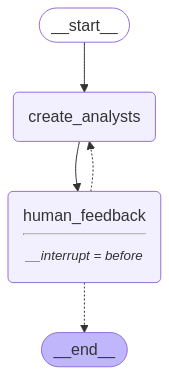

In [4]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas to analyze a stock. Follow these instructions carefully:

1. First, do an unbiased review of the research inquiry for the stock {STOCK_TICKER}: {topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}

3. Determine the most interesting themes based on the inquiry and / or feedback above.
                    
4. Pick the top {min_analysts} to {max_analysts} themes. Minimize overlap between themes, ensuring they are distinct.

5. Assign one analyst to each theme. Make sure they only focus on the stock mentioned in the inquiry."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    topic=state['topic']
    min_analysts=state['min_analysts']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(STOCK_TICKER=STOCK_TICKER,
                                                 topic=topic,
                                                 human_analyst_feedback=human_analyst_feedback,
                                                 min_analysts=min_analysts,
                                                 max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Conduct Interviews (Analyst <=> Expert feedback loop)

In [5]:
import operator
from typing import List, Annotated
from langgraph.graph import MessagesState
from typing_extensions import TypedDict

def first_binary(a, b):
    return a

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[List[str], operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [6]:
#langchain's research model gives a clear set of question_instructions, which I've used here
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your ultimate goal is to **seek alpha**—identify unique, actionable insights that can provide a competitive edge in the market.

You should focus on producing insights that are:

1. Interesting: Surprising or non-obvious ideas that challenge conventional thinking or reveal overlooked patterns.

2. Specific: Avoid vague generalities. Push for detailed examples, real-world use cases, and concrete mechanisms.

3. Helpful: Above all, your insights should be useful for making smarter investment or trading decisions.
Think about how each point could lead to alpha—either through better timing, allocation, or risk management.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your analyst persona, and then ask your first question.

Continue to ask follow-up questions to drill deeper and refine your understanding, always with the intent of uncovering alpha-generating information.

When you're confident you've extracted valuable insights, close the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

In [7]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [8]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

In [9]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

In [10]:
#SEARCH FUNCTIONS

import yfinance as yf
import ta

def search_market_data(state: InterviewState):
    """ Retrieve and summarize market data using Yahoo Finance + pandas_ta """

    global STOCK_TICKER
    analyst = state["analyst"]

    try:
        df = yf.Ticker(STOCK_TICKER).history(period="6mo", interval="1d")
    except Exception as e:
        return {"context": [f"<Document source='yfinance_error'>Could not fetch data: {e}</Document>"]}

    df['rsi'] = ta.momentum.RSIIndicator(close=df['Close']).rsi()
    df['ema'] = ta.trend.EMAIndicator(close=df['Close'], window=20).ema_indicator()

    summary = df[['Close', 'rsi', 'ema']].dropna().tail(30).to_string(index=False)

    formatted = f"""
<Document source="yfinance/{STOCK_TICKER}">
Market Data Summary for {STOCK_TICKER} (Last 30 days):

{summary}
</Document>
"""

    return {"context": [formatted]}


def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 


In [11]:
import io
import base64
import matplotlib.pyplot as plt
import yfinance as yf

def generate_stock_perf_chart_base64(benchmark_ticker: str = "^GSPC"):
    global STOCK_TICKER
    stock = yf.Ticker(STOCK_TICKER)
    benchmark = yf.Ticker(benchmark_ticker)

    df_stock = stock.history(period="2y")
    df_benchmark = benchmark.history(period="2y")

    df_stock['Return'] = df_stock['Close'].pct_change().fillna(0).add(1).cumprod().sub(1) * 100
    df_benchmark['Return'] = df_benchmark['Close'].pct_change().fillna(0).add(1).cumprod().sub(1) * 100

    def plot_perf():
        plt.figure(figsize=(10, 5))
        plt.plot(df_stock.index, df_stock['Return'], label=f'{STOCK_TICKER} Change %', color='blue')
        plt.plot(df_benchmark.index, df_benchmark['Return'], label='S&P 500 Change %', color='red')
        plt.title(f"{STOCK_TICKER} vs S&P 500 - % Change Over Past 2 Years")
        plt.xlabel("Date")
        plt.ylabel("Change %")
        plt.legend()
        plt.grid(True)

    # Convert the plot to base64
    buf = io.BytesIO()
    plot_perf()
    plt.tight_layout()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    return base64.b64encode(buf.read()).decode('utf-8')


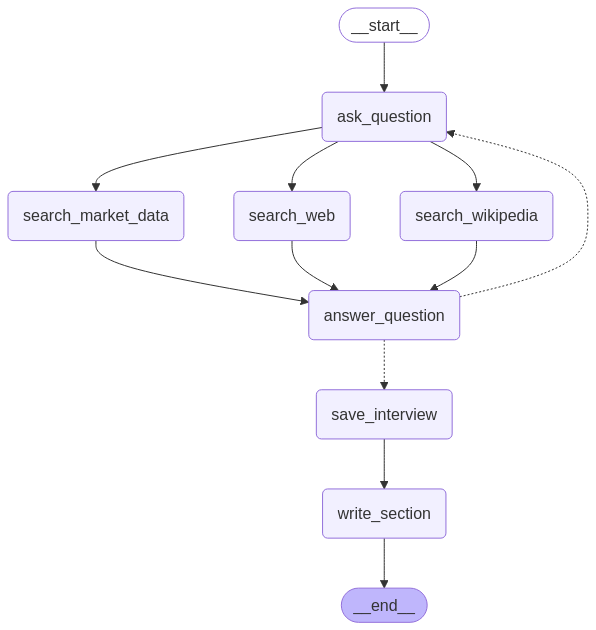

In [12]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_market_data", search_market_data)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_market_data")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_market_data", "answer_question")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [13]:
class ResearchGraphState(TypedDict):
    topic: str # Research topic
    min_analysts: int # min analyst range
    max_analysts: int # max analyst range
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

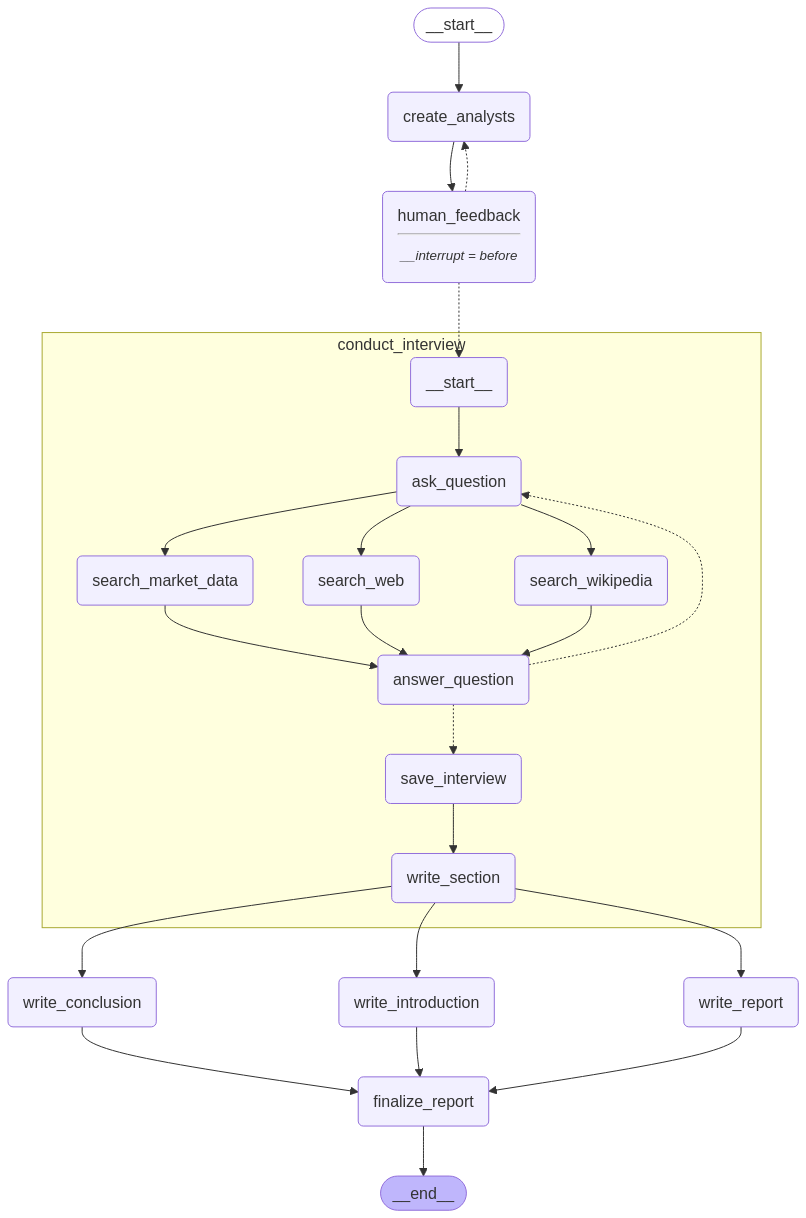

In [14]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on the {STOCK_TICKER} stock about {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on the {STOCK_TICKER} stock about this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. Ensure any Latex is encapsulated properly (no hanging dollar signs)
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(STOCK_TICKER=STOCK_TICKER, topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on the {STOCK_TICKER} stock about {topic}.

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(STOCK_TICKER=STOCK_TICKER, topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(STOCK_TICKER=STOCK_TICKER, topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ This is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion. """
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]

    if sources is not None:
        final_report += "\n\n## Sources\n" + sources

    chart_perf = generate_stock_perf_chart_base64()


    if chart_perf or chart_pe:
        final_report += "\n\n## Visuals\n"
        if chart_perf:
            final_report += f"![Performance Chart](data:image/png;base64,{chart_perf})\n"

    return {"final_report": final_report}


# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Testing

In [15]:
#Input Inquiry + Human guidelines for Analyst Generation

min_analysts = 4
max_analysts = 6
STOCK_TICKER = input("Stock Ticker:")
topic = input("Research Inquiry:")
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic, "min_analysts":min_analysts, "max_analysts":max_analysts,}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Stock Ticker: AAPL
Research Inquiry: financial sector analysis


Name: Jordan Lee
Affiliation: Tech Equity Research Group
Role: Financial Performance Analyst
Description: Jordan focuses on analyzing AAPL's financial statements, revenue growth, and profitability metrics to assess the company's financial health and performance in the tech sector.
--------------------------------------------------
Name: Samantha Chen
Affiliation: Market Trends Institute
Role: Market Sentiment Analyst
Description: Samantha examines market trends, investor sentiment, and stock price movements related to AAPL, providing insights into how external factors influence the stock's performance.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Consumer Insights Agency
Role: Consumer Behavior Analyst
Description: Michael investigates consumer preferences and purchasing behavior regarding AAPL products, analyzing how these factors impact sales and market share.
--------------------------------------------------
Name: Emily Rodriguez
Affiliatio

In [16]:
#HUMAN INPUT
human_feedback = input("Any changes you want to make to the analysts?")
graph.update_state(thread, {"human_analyst_feedback": 
                                human_feedback}, as_node="human_feedback")

Any changes you want to make to the analysts? 


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f01a46a-fbf9-6a23-8002-c665ce63ef74'}}

In [17]:
# Check
new_analysts = []

for event in graph.stream(None, thread, stream_mode="values"):
    if 'analysts' in event:
        new_analysts = event['analysts']

# Now print only the last seen
for analyst in new_analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)


Name: Jordan Lee
Affiliation: Tech Equity Research Group
Role: Financial Performance Analyst
Description: Jordan focuses on analyzing AAPL's financial statements, revenue growth, and profitability metrics to assess the company's financial health and performance in the tech sector.
--------------------------------------------------
Name: Samantha Chen
Affiliation: Market Trends Institute
Role: Market Sentiment Analyst
Description: Samantha examines market trends, investor sentiment, and stock price movements related to AAPL, providing insights into how external factors influence the stock's performance.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Consumer Insights Agency
Role: Consumer Behavior Analyst
Description: Michael investigates consumer preferences and purchasing behavior regarding AAPL products, analyzing how these factors impact sales and market share.
--------------------------------------------------
Name: Emily Rodriguez
Affiliatio

In [18]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f01a46c-d9e8-613c-8006-d3624fb9f811'}}

In [19]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


# Financial Sector Analysis of Apple Inc. (AAPL)

## Introduction

This report delves into the financial sector analysis of Apple Inc. (AAPL), highlighting its robust financial health, market trends, and consumer behavior. We begin by examining AAPL's financial performance, focusing on revenue growth and profitability, particularly in its expanding services segment. Next, we analyze market trends and investor sentiment, revealing how external factors influence stock performance. We also explore consumer preferences, emphasizing brand loyalty among younger demographics. Additionally, the regulatory landscape's impact on AAPL's operations is assessed, alongside macroeconomic indicators shaping its business model. Finally, we provide valuation insights, offering a comprehensive view of AAPL's investment potential.

---



Apple Inc. (AAPL) continues to be a significant player in the financial sector, demonstrating robust financial health and resilience amid various market challenges. Recent analyses reveal a multifaceted view of AAPL's performance, driven by internal strategies and external economic factors.

AAPL's financial performance has been characterized by consistent revenue growth, particularly in its services segment, which has become a crucial driver of profitability. The services revenue grew by 9% year-over-year in FY2023, reaching $85 billion, and is projected to potentially hit $100 billion by FY2025. This shift towards higher-margin services, which now account for 22% of total sales, underscores a strategic pivot that enhances overall financial stability [1][2][3]. Despite a slight decline in product sales, particularly in the iPhone category, the company's ability to maintain a loyal customer base—85% of iPhone sales come from repeat customers—highlights strong brand loyalty and satisfaction [4].

However, AAPL's stock performance has been influenced by external factors, including macroeconomic conditions, geopolitical events, and regulatory pressures. Recent fluctuations in AAPL's stock price, ranging from a high of $239.07 to a low of $172.42, reflect a volatile market environment shaped by rising interest rates, inflation, and consumer spending patterns [5][6]. Analysts note that during periods of economic expansion, AAPL tends to perform well, but economic downturns can lead to reduced discretionary spending, adversely affecting sales and stock valuation [7].

The regulatory landscape also poses challenges for AAPL, with increasing scrutiny from regulatory bodies regarding antitrust issues and compliance with new legislation such as the European Union's Digital Markets Act. These regulations may necessitate adjustments to AAPL's business model, impacting its operational strategies and market positioning [8][9]. While regulatory pressures can be burdensome, they may also present opportunities for innovation and differentiation in the marketplace.

Valuation insights reveal a complex picture for AAPL stock, with various financial models suggesting differing intrinsic values. A Discounted Cash Flow (DCF) model estimates an intrinsic share price of $178.48, while a Dividend Discount Model suggests a lower valuation of $125.60 [10][11]. The current trading price of approximately $223.89 indicates that AAPL may be overvalued based on certain intrinsic value calculations, yet the company's strong market position and growth potential warrant close monitoring [12].

In summary, AAPL's financial health is bolstered by innovative strategies and a solid international presence, but it must navigate a complex interplay of market trends, consumer behavior, and regulatory challenges. Understanding these dynamics is crucial for investors looking to make informed decisions regarding AAPL's future performance.


---

## Conclusion

In summary, Apple Inc. (AAPL) showcases a robust financial health characterized by diverse revenue streams and a strategic pivot towards its services segment, which is projected to drive future growth. Despite facing external pressures from macroeconomic factors, regulatory challenges, and shifting consumer preferences, AAPL has demonstrated resilience through strong brand loyalty and innovative product offerings. The interplay of market trends and investor sentiment further complicates the stock's performance, highlighting the need for vigilance among investors. As AAPL navigates these complexities, its ability to adapt and innovate will be crucial in maintaining its competitive edge and delivering value to shareholders in the evolving tech landscape.

## Sources
[1] https://yfinance.com/AAPL  
[2] https://ecommercedb.com/insights/inside-apple-revenue-latest-sales-figures-and-key-insights/4992  
[3] https://www.forrester.com/blogs/apple-sales-and-profits-analysis-for-fy-2023-top-10-insights/  
[4] https://www.start.io/blog/apple-target-market-analysis-apple-demographics-marketing-strategy-competitors/  
[5] https://www.mdpi.com/2227-7390/11/23/4830  
[6] https://fxopen.com/blog/en/oa-apple-report-drives-bearish-sentiment-for-aapl-stock/  
[7] https://capital.com/apple-stock-price-in-10-years  
[8] https://www.sec.gov/Archives/edgar/data/320193/000032019323000106/aapl-20230930.htm  
[9] https://nyujlpp.org/wp-content/uploads/2024/07/JLPP-26-3-Trivedi.pdf  
[10] https://students.tippie.uiowa.edu/sites/students.tippie.uiowa.edu/files/2024-04/s24_AAPL.pdf  
[11] https://blog.wisesheets.io/master-sensitivity-analysis-in-excel-for-stocks/  
[12] https://www.tikr.com/blog/why-apple-stock-might-actually-be-a-good-stock-to-buy-today?ref=tikrblo

## Visuals
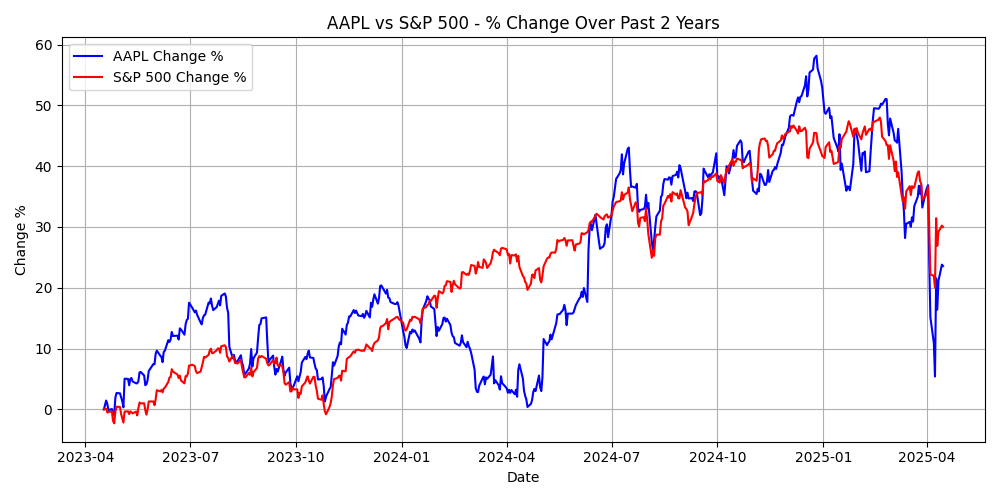


In [20]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)